# Concept Network Tool

It is recommended to run all code chunks in order.

## Import data

Here user has to define the following:

- `DATA_PATH`: the folder including data files
- `DATA_FILES` : automatically detected `csv` files from `DATA_PATH` 


In [1]:
# Load R packages
if (!require("pacman")){ 
    install.packages("pacman")
}

pacman::p_load(tidyverse, udpipe, stopwords, wordcloud, igraph, ggraph, textrank, textreuse, patchwork, RColorBrewer)

In [3]:
DATA_PATH <- "processed_data"
DATA_FILES <- list.files(DATA_PATH, pattern = ".csv",full.names = TRUE,)

cat("Available datasets in", DATA_PATH, "\n",
    
    paste(paste(1:length(DATA_FILES) ,"\t", DATA_FILES, "\n"), sep = "\n"), "\n")


df_path <- DATA_FILES[as.numeric(readline(prompt="Select data: "))]
df_raw <- read.csv(df_path)

cat(df_path, "selected.")

Available datasets in processed_data 
 1 	 processed_data/hs2014_processed.csv 
 2 	 processed_data/techeldercare_Q59_processed.csv 
 3 	 processed_data/techeldercare_Q62_processed.csv 
 
Select data: 1
processed_data/hs2014_processed.csv selected.

## Stopword removal

R package [`stopwords`](https://cran.r-project.org/web/packages/stopwords/readme/README.html) includes three Finnish stop word lists: 

    1. nltk
    2. snowball
    3. stopwords-iso


Then filter the data by excluding words from the stop word list.

In [4]:
sw_lists_available <- sort(stopwords_getsources()[unlist(lapply(stopwords_getsources(), function(x) ifelse("fi" %in% stopwords_getlanguages(x), TRUE, FALSE)))])
sw_lists <- c(lapply(sw_lists_available, function(y) stopwords("fi", y)), list(NA))
sw_list_sizes <- lapply(sw_lists, function(z) ifelse(length(z) > 1, length(z), 0))
                
sw_options <- c(paste(c(sw_lists_available, "None"), paste0("(", sw_list_sizes, " words)")), "Custom")
                        
cat("Stopword lists available:\n",paste(paste(1:length(sw_options) ,"\t", sw_options, "\n"), sep = "\n"), "\n")

sw_selection <- readline(prompt="Select stopword list: ")                        

if(as.numeric(sw_selection) == length(sw_options)) {
    custom_stopwords <- readline(prompt="List all stopwords. Separate with a comma.\n")
    stopword_list <- trimws(stringr::str_split(custom_stopwords, ",", simplify = TRUE), "both")
    cat(length(stopword_list), "stopwords saved.")
} else {
    stopword_list <- sw_lists[[as.numeric(sw_selection)]]
    cat("Stopwords:\n", paste(stopword_list, collapse = ", "), sep ="")
}

# Remove all the stop words above from the data
df <- df_raw %>%
    mutate(lemma = str_replace(lemma, "#", "")) %>%
    filter(!lemma %in% stopword_list) 
       
# Vocabulary       
vocab <- unique(df$lemma)                      

Stopword lists available:
 1 	 nltk (229 words) 
 2 	 snowball (68 words) 
 3 	 stopwords-iso (847 words) 
 4 	 None (0 words) 
 5 	 Custom 
 
Select stopword list: 4
Stopwords:
NA

# Options

In [5]:
# seed number, used for network plot layouts
seed_num <- 2022

# relevant words by part of speech
relevant_pos <- c("NOUN", "VERB", "ADJ", "ADV")

# minimum number of occurences
min_occurences <- 5

# Data summary


In [6]:
words_table <-  df %>%
    summarize(respondents = n_distinct(doc_id),
        total_tokens = n(),
        unique_words = length(unique(token)),
        unique_lemmas = length(unique(lemma))) 


pos_table <-  df %>% 
    count(upos, sort = TRUE) %>%
    pivot_wider(names_from = upos, values_from = n, values_fill = 0)


words_table
pos_table


respondents,total_tokens,unique_words,unique_lemmas
<int>,<int>,<int>,<int>
3491,103670,18238,7814


NOUN,PUNCT,VERB,ADV,AUX,PRON,ADJ,CCONJ,SCONJ,ADP,NUM,PROPN,SYM,INTJ,X
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
20992,16321,15451,11151,10231,9420,9022,4846,3743,1683,406,232,76,49,47


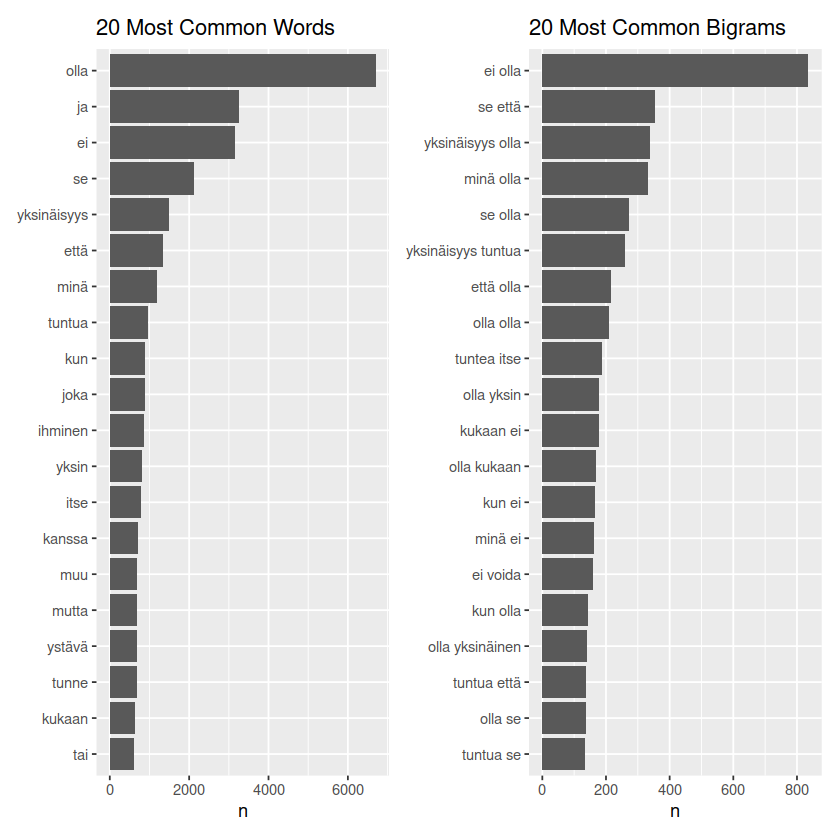

In [7]:
word_freqs <- df %>% 
  filter(dep_rel != "punct") %>%
  count(lemma, sort = TRUE) %>%
  slice_max(n, n = 20) %>%
  mutate(lemma = reorder(lemma, n)) %>%
  ggplot(aes(n, lemma)) +
  geom_col() +
  labs(y = NULL, title = "20 Most Common Words")

bigram_freqs <- df %>%
  filter(dep_rel != "punct") %>%
   mutate(bigram = txt_nextgram(lemma, n = 2)) %>%
  count(bigram, sort = TRUE) %>%
  slice_max(n, n = 20) %>%
  mutate(bigram = reorder(bigram, n)) %>%
  ggplot(aes(n, bigram)) +
  geom_col() +
  labs(y = NULL, title = "20 Most Common Bigrams")

  word_freqs + bigram_freqs

## Word Cloud

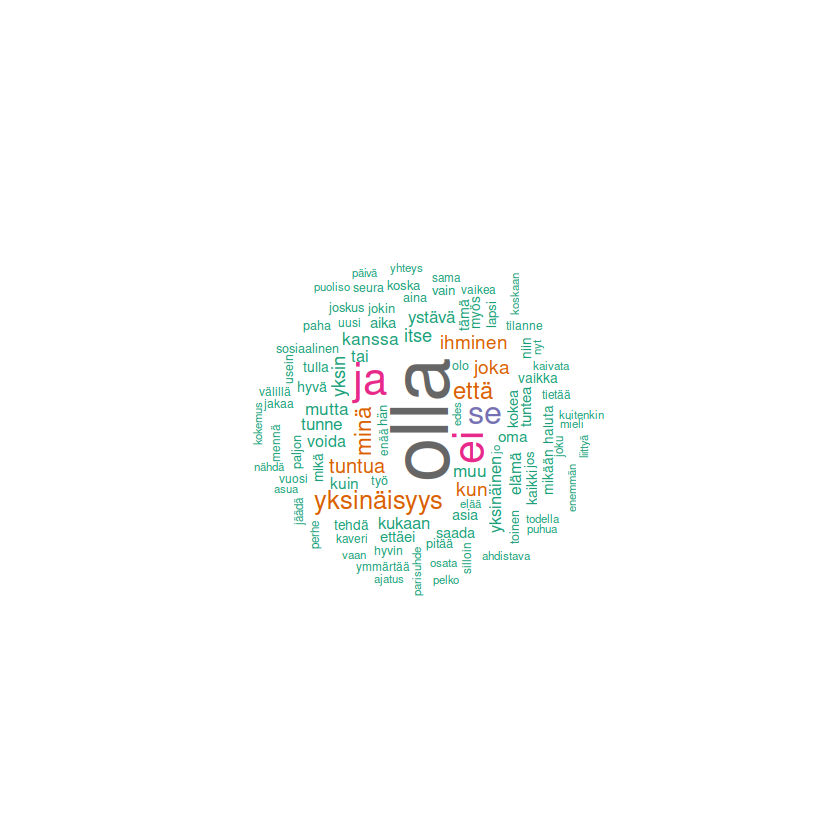

In [8]:
word_cloud_data <- df %>% 
    filter(dep_rel != "punct") %>%
    count(lemma, sort = TRUE) 

wordcloud(words = word_cloud_data$lemma, 
        freq = word_cloud_data$n,
        max.words= 100,
        random.order=FALSE,
        rot.per=0.35,
        colors=RColorBrewer::brewer.pal(8, "Dark2"))

# Functions

In [9]:
find_concepts <- function(data, concept) {
    
    if(str_detect(concept, ",")){
        concept <- str_extract_all(concept, pattern = "\\w+") %>% 
        unlist()
        
        cat("Displaying results including following concepts:", "\n",
            paste(paste(1:length(concept) ,"\t", concept, "\n"), sep = "\n"), "\n")
    }
    
    concept_keywords <- data %>% 
        filter(word1 %in% concept)  %>%
        pull(keyword)
    
    all_concepts <- data %>% 
        filter(keyword %in% concept_keywords)
    
    return(all_concepts)
}

get_edges <- function(data, concept, threshold = NULL) {
    df <-  data %>%
    find_concepts(concept = concept) %>%
    select(word1, word2, freq) %>%
    group_by(word1,word2) %>%
    summarize(n = sum(freq), .groups = "drop") %>%
    rename(from = word1,
          to = word2)
    
    if(!is.null(threshold)) {
        df <- df %>% filter(n >= threshold)
    }
    
    return(df)
} 

get_nodes <- function(data, vocab) {
    df <- data %>% filter(lemma %in% vocab)
    
    return(df)
}

plot_graph <- function(edges, nodes, concepts, ...) {  
    
nodes <- nodes %>%
    mutate(is_concept = factor(ifelse(lemma %in% concepts, 0, 1), levels = 0:1, labels = c("Concept word", "Regular word")))

p <- graph_from_data_frame(edges, directed = FALSE, vertices = nodes) %>%
    ggraph(layout = "kk") +
    geom_edge_link(aes(width = n, edge_alpha = n), edge_colour = "lightblue") +
    geom_node_point(aes(size = pagerank)) +
    geom_node_text(aes(label = name, col = is_concept), check_overlap = TRUE, repel = TRUE) +
    scale_color_manual("", values = c("Concept word" = "red", "Regular word" = "black")) +
    theme_graph() +
    labs(
        title = "Textrank extracted keyword occurences",
        subtitle = "Adjectives, Nouns, Verbs",
         ... ) +
    theme(legend.position = "right")    

return(p)
}

textrank_table <- function(x, n = 25) {
    keyword_table <- x$keywords %>%
    filter(ngram > 1 & freq > 1) %>%
    slice_max(freq, n = n)
    
    return(keyword_table)
}

textrank_graph <- function(x, input_word, threshold) {
   
    keyword_data <- x$keywords %>% 
        filter(ngram > 1 & freq > 1) %>% 
        mutate(word2 = strsplit(keyword, "-")) %>% 
        unnest(word2) %>%
        group_by(keyword) %>%
        mutate(word1 = lag(word2)) %>%
        relocate(word1, .before = word2) %>%
        ungroup() %>%
        filter(!is.na(word1))


    textrank_data <- data.frame(pagerank = keyw$pagerank$vector) %>%
        rownames_to_column("lemma") 


    edges <- get_edges(keyword_data, concept = input_word, threshold = threshold)
    keyword_vocab <- unique(c(edges$from, edges$to))
    nodes <- get_nodes(textrank_data, vocab = keyword_vocab)    
    plot_graph(edges, nodes, concepts = query_list, caption = paste("Min.", threshold, "occurences."))
}


## Textrank keywords

In [10]:
keyw <- textrank_keywords(df$lemma, relevant = df$upos %in% relevant_pos)

In [11]:
textrank_table(keyw, n = 20)

keyword,ngram,freq
<chr>,<int>,<int>
ei-olla,2,306
olla-yksin,2,113
minä-olla,2,95
olla-yksinäinen,2,95
yksinäisyys-tuntua,2,93
yksinäisyys-olla,2,88
hyvä-ystävä,2,57
muu-ihminen,2,50
ihminen-kanssa,2,49


# Concept extraction

Input words that represent the question.

In [12]:
query <- tolower(readline(prompt="Enter words (separated by a comma):"))

query_list <- str_extract_all(query, pattern = "\\w+") %>% unlist()

set.seed(seed_num)

while(TRUE) {
   valid_words = query_list %in% vocab
    
    if(tolower(query) == "c"){
        interactive_status <- FALSE
        cat("Stopping.")
        break
    }
    

    
    if(any(valid_words != TRUE)){
        
        cat("Following words not found in vocabulary:", paste(query_list[!valid_words], collapse = ", "), "\n")
        flush.console()
        
        query <- tolower(readline(prompt="Re-enter words: (or C to stop)"))
        query_list <- str_extract_all(query, pattern = "\\w+") %>% unlist()
        
    } 
    
    if(all(valid_words) == TRUE){
        interactive_status <- TRUE
        found_data = df %>% filter(lemma %in% query_list)
        break
    }

   
}

Enter words (separated by a comma):yksinäisyys, tunne, tuntea


Displaying results including following concepts: 
 1 	 yksinäisyys 
 2 	 tunne 
 3 	 tuntea 
 


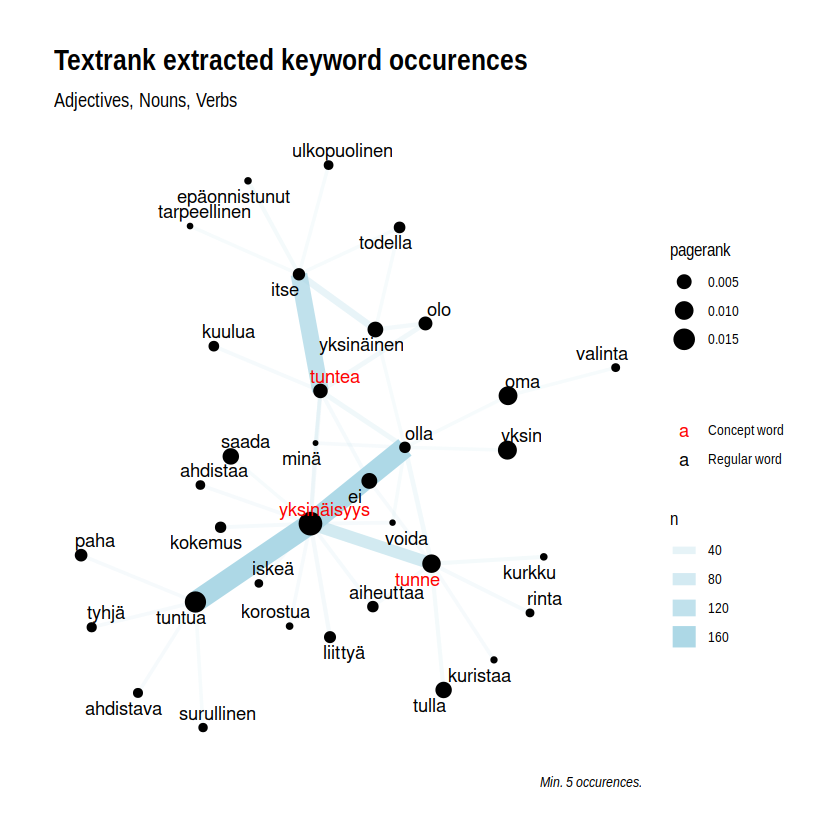

In [14]:
textrank_graph(keyw, input_word = query, threshold = min_occurences)